# Plots zur Datenvisualisierung

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

In [3]:
# Load data
bike_data = pd.read_csv("../data/full_bike_data_preprocessed.csv", low_memory=False)
bike_data['timestamp'] = pd.to_datetime(bike_data['timestamp'], errors='coerce')
bike_data['timestamp'] = bike_data['timestamp'].dt.tz_convert('Europe/Berlin') # konvertieren um Zeitumstellungsprobleme zu lösen


In [10]:
# Get data for specific city
city = "Stadt Tübingen"
city_data = bike_data[bike_data['city'] == city]
city_data['counter_site'].unique()

array(['Unterführung Steinlach/Karlstraße Südseite - Steinlachallee',
       'Fuß- & Radtunnel Südportal - Derendinger Allee',
       'Neckartalradweg Hirschau - parallel L371',
       'Unterführung Steinlach/Karlstraße Südseite - Steinlachallee_2',
       'Fuß- & Radtunnel Südportal - Derendinger Allee_3',
       'Neckartalradweg Hirschau - parallel L371_3'], dtype=object)

In [27]:
# Get max count
max_count = city_data['count'].max()
max_count

np.float64(1836.5)

#### Polar Plots

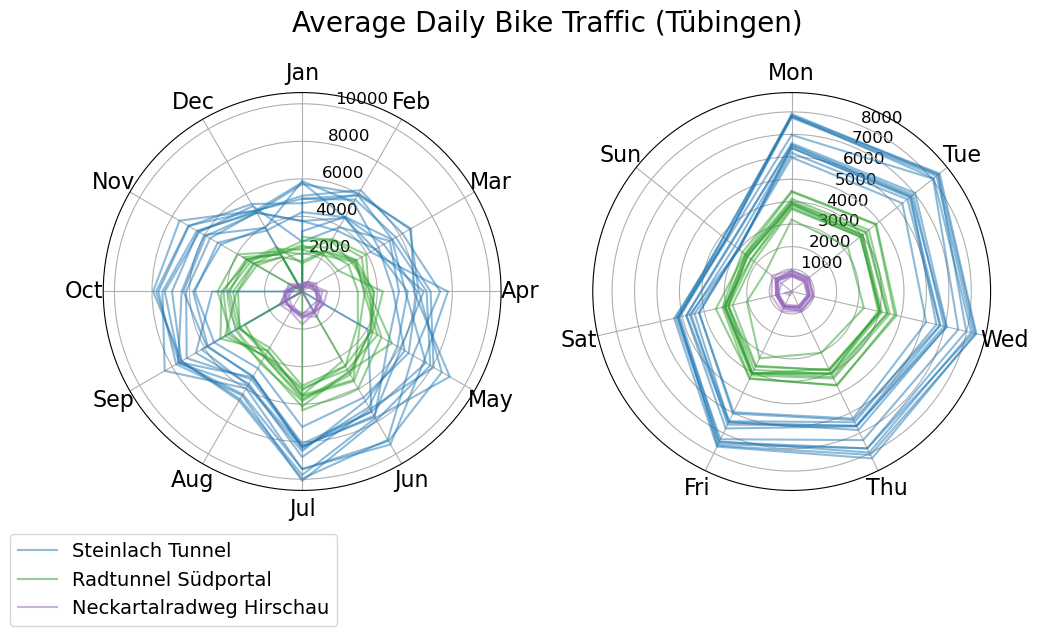

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# --- CONFIGURATION ---
counter_config = {
    'Unterführung Steinlach/Karlstraße Südseite - Steinlachallee': {
        'label': 'Steinlach Tunnel', 'color': '#1f77b4'
    },
    'Unterführung Steinlach/Karlstraße Südseite - Steinlachallee_2': {
        'label': 'Steinlach Tunnel', 'color': '#1f77b4'             
    },
    'Fuß- & Radtunnel Südportal - Derendinger Allee': {
        'label': 'Radtunnel Südportal', 'color': "#2ca02c"
    },
    'Fuß- & Radtunnel Südportal - Derendinger Allee_3': {
        'label': 'Radtunnel Südportal', 'color': '#2ca02c'
    },
    'Neckartalradweg Hirschau - parallel L371': {
        'label': 'Neckartalradweg Hirschau', 'color': '#9467bd'
    },
    'Neckartalradweg Hirschau - parallel L371_3': {
        'label': 'Neckartalradweg Hirschau', 'color': '#9467bd'
    }
}

def prepare_data(df):
    if df['timestamp'].dt.tz is None:
        df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize('UTC')
    df['timestamp'] = df['timestamp'].dt.tz_convert('Europe/Berlin')
    
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['weekday'] = df['timestamp'].dt.weekday
    return df

def plot_on_axis(ax, df, period_col, labels, mode):
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]
    
    counters = df['counter_site'].unique()
    
    for counter in counters:
        settings = counter_config.get(counter, {'label': counter, 'color': 'gray'})
        c_label = settings['label']
        c_color = settings['color']
        
        subset = df[df['counter_site'] == counter]
        years = sorted(subset['year'].unique())
        
        for year in years:
            year_data = subset[subset['year'] == year]
            
            # --- NEW AGGREGATION LOGIC ---
            if mode == 'monthly_daily_avg':
                # Calculate Average Hourly Count, then multiply by 24 for Daily Average
                g = year_data.groupby(period_col)['count'].agg(['sum', 'count'])
                # sum = total bikes, count = total hours observed
                # (Total Bikes / Total Hours) * 24 = Average Bikes Per Day
                g['val'] = (g['sum'] / g['count']) * 24
                
                # Reindex ensures we have 12 months, fill missing with NaN (broken line) or 0
                g = g.reindex(range(1, 13), fill_value=None) 
                values = g['val'].fillna(0).tolist() # Use 0 to keep the loop closed, or handle gaps
                
            elif mode == 'weekday_mean':
                g = year_data.groupby(period_col)['count'].mean()
                g = g * 24  # Average Daily Count
                g = g.reindex(range(0, 7), fill_value=0)
                values = g.tolist()
            
            values += values[:1]
            
            # Plot
            lbl = c_label if year == years[0] else ""
            ax.plot(angles, values, color=c_color, linewidth=1.5, alpha=0.5, label=lbl)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=16)
    ax.tick_params(axis='y', labelsize=12)
    if mode == 'monthly_daily_avg':
        ax.set_rlabel_position(10)

# --- EXECUTION ---
df_clean = prepare_data(city_data) # Load your data here

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(10, 5))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plot_on_axis(ax1, df_clean, 'month', months, 'monthly_daily_avg')

weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plot_on_axis(ax2, df_clean, 'weekday', weekdays, 'weekday_mean')

fig.suptitle("Average Daily Bike Traffic (Tübingen)", fontsize=20, y=1.02, x=0.5)

handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
unique_labels = [lbl for lbl in by_label.keys() if lbl != ""]
unique_handles = [by_label[lbl] for lbl in unique_labels]

fig.legend(unique_handles, unique_labels, loc='center right', bbox_to_anchor=(0.3, -0.12), fontsize=14)
plt.tight_layout()
plt.show()
# Save figure
# Create figures directory if it doesn't exist
import os
os.makedirs("../figures", exist_ok=True)
fig.savefig("../figures/polar_bike_traffic_tuebingen.png", dpi=300, bbox_inches='tight')

#### Heatmaps

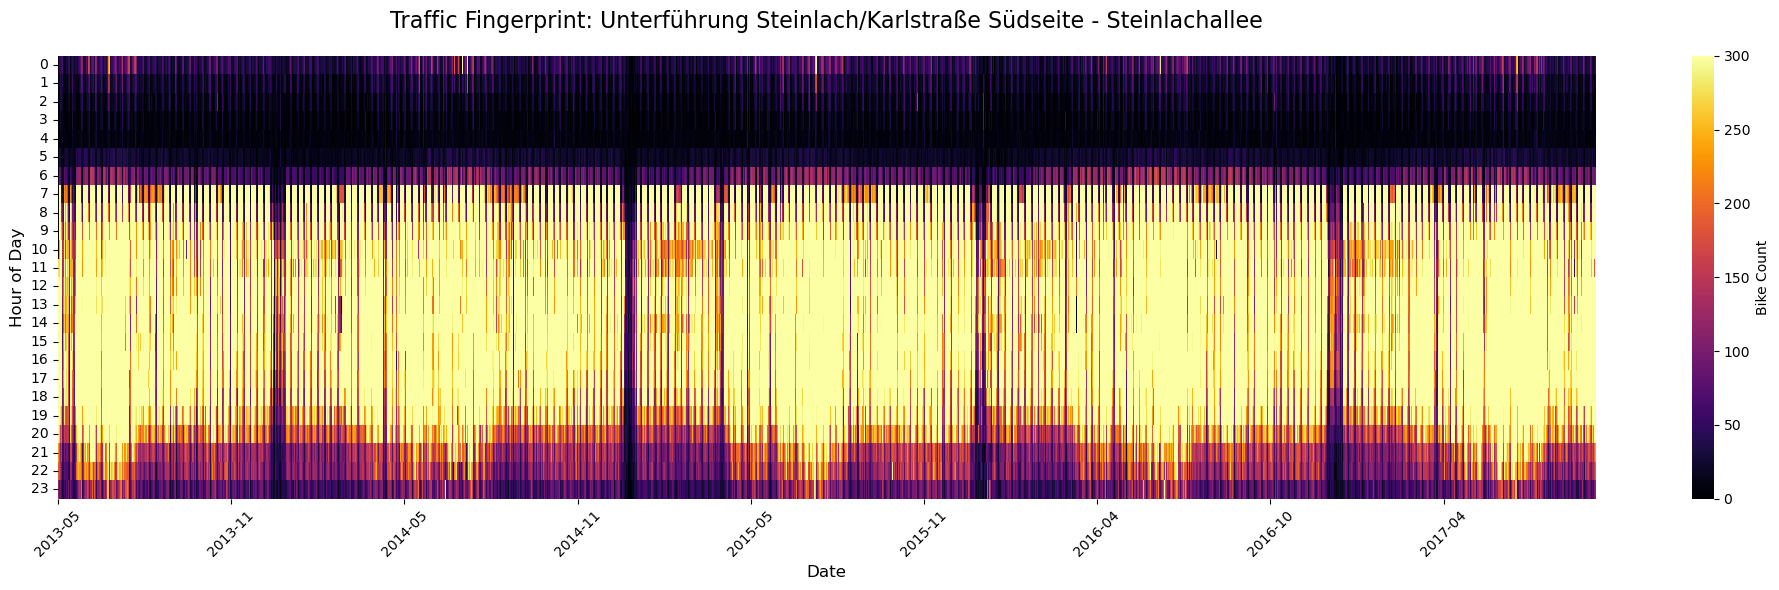

In [52]:
warnings.filterwarnings("ignore")

# --- DATA PREPARATION ---
# (Assuming 'city_data' is your raw dataframe)
df = city_data.copy()

# 1. Convert timestamp
if df['timestamp'].dt.tz is None:
    df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize('UTC')
df['timestamp'] = df['timestamp'].dt.tz_convert('Europe/Berlin')

# 2. Filter for just ONE counter to make the plot readable
# (Heatmaps get messy if you mix locations. Choose your main one.)
target_counter = 'Unterführung Steinlach/Karlstraße Südseite - Steinlachallee'
df_site = df[df['counter_site'] == target_counter].copy()

# 3. Create Pivot Table for Heatmap
# Index (Y-Axis) = Hour
# Columns (X-Axis) = Date
df_site['date'] = df_site['timestamp'].dt.date
df_site['hour'] = df_site['timestamp'].dt.hour

# Pivot: Rows=Hour, Cols=Date, Values=Count
heatmap_data = df_site.pivot_table(index='hour', columns='date', values='count', aggfunc='sum').fillna(0)

# --- PLOTTING ---
plt.figure(figsize=(20, 6))

# Create the heatmap
# vmin/vmax: Cap the color scale to avoid outliers washing out the plot (e.g., max 500 bikes)
ax = sns.heatmap(heatmap_data, cmap='inferno', vmin=0, vmax=300, cbar_kws={'label': 'Bike Count'})

# --- FORMATTING ---
plt.title(f"Traffic Fingerprint: {target_counter}", fontsize=16, pad=20)
plt.ylabel("Hour of Day", fontsize=12)
plt.xlabel("Date", fontsize=12)

# Improve X-Axis Labels (The pivot table creates thousands of labels, we only want a few)
# Get current labels and locations
x_dates = df_site['date'].unique()
x_locs = ax.get_xticks()

# Create a locator for every ~6 months
from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.ticker as ticker

# Custom formatting for x-axis to show Year-Month
# Since Seaborn heatmaps are categorical, we need to map indices roughly to dates
tick_frequency = 180 # Show label every ~180 days
ax.set_xticks(range(0, len(x_dates), tick_frequency))
ax.set_xticklabels([x_dates[i].strftime('%Y-%m') for i in range(0, len(x_dates), tick_frequency)], rotation=45)

plt.yticks(rotation=0) # Keep hour numbers horizontal
plt.tight_layout()
plt.show()

Maybe we should think about leaving this in and explaining things we considered during the processing to show that we really thought about pitfalls of the data

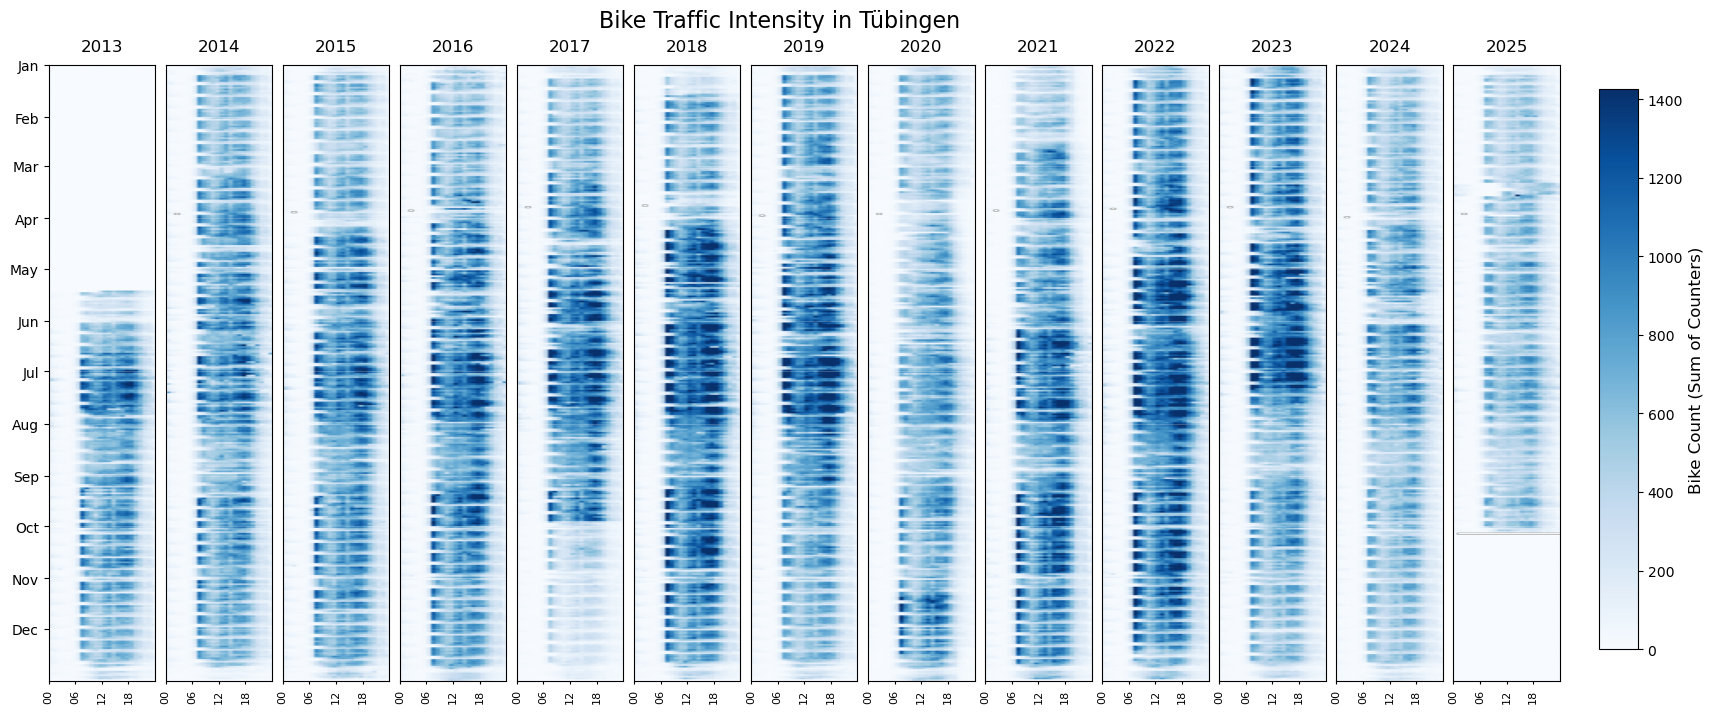

In [54]:
warnings.filterwarnings("ignore")

# --- CONFIGURATION (Same as before) ---
counter_config = {
    'Unterführung Steinlach/Karlstraße Südseite - Steinlachallee': {'label': 'Steinlach', 'color': '#1f77b4'},
    'Unterführung Steinlach/Karlstraße Südseite - Steinlachallee_2': {'label': 'Steinlach', 'color': '#1f77b4'},
    'Fuß- & Radtunnel Südportal - Derendinger Allee': {'label': 'Radtunnel', 'color': "#2ca02c"},
    'Fuß- & Radtunnel Südportal - Derendinger Allee_3': {'label': 'Radtunnel', 'color': '#2ca02c'},
    'Neckartalradweg Hirschau - parallel L371': {'label': 'Neckartal', 'color': '#9467bd'},
    'Neckartalradweg Hirschau - parallel L371_3': {'label': 'Neckartal', 'color': '#9467bd'}
}

def prepare_data(df):
    if df['timestamp'].dt.tz is None:
        df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize('UTC')
    df['timestamp'] = df['timestamp'].dt.tz_convert('Europe/Berlin')
    
    # Filter only for the counters we want
    df = df[df['counter_site'].isin(counter_config.keys())].copy()
    
    # Aggregate: Sum all selected counters to get "Total City Volume"
    # This creates a single robust time series
    df_agg = df.groupby('timestamp')['count'].sum().reset_index()
    
    df_agg['year'] = df_agg['timestamp'].dt.year
    df_agg['day_of_year'] = df_agg['timestamp'].dt.dayofyear
    df_agg['hour'] = df_agg['timestamp'].dt.hour
    
    return df_agg

def create_yearly_strip_plot(df):
    years = sorted(df['year'].unique())
    n_years = len(years)
    
    # Setup Figure: 1 row, N columns (one per year)
    # sharey=True keeps the months aligned
    fig, axes = plt.subplots(1, n_years, sharey=True, figsize=(n_years * 1.5, 8))
    
    # Global Color Settings
    # Calculate vmin/vmax across the whole dataset so colors are comparable between years
    vmin, vmax = 0, df['count'].quantile(0.99) # Cap at 99th percentile to ignore extreme outliers
    
    # Y-Axis formatting (Months)
    # We create a dummy index for 366 days to handle leap years roughly
    month_starts = [0, 31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    for i, year in enumerate(years):
        ax = axes[i] if n_years > 1 else axes
        
        # 1. Prepare Data for this Year
        df_year = df[df['year'] == year]
        
        # Pivot: Index=DayOfYear (1-366), Columns=Hour (0-23)
        pivot = df_year.pivot_table(index='day_of_year', columns='hour', values='count', aggfunc='sum')
        
        # Reindex to ensure every year has exactly 366 rows (for alignment) and 24 columns
        # Fill missing data with 0 (or NaN if you prefer white gaps)
        pivot = pivot.reindex(index=range(1, 367), columns=range(0, 24), fill_value=0)
        
        # 2. Plot Heatmap
        # origin='upper' puts Jan at the top
        # aspect='auto' allows the strip to stretch vertically
        im = ax.imshow(pivot, cmap='Blues', aspect='auto', 
                       vmin=vmin, vmax=vmax, origin='upper',
                       extent=[0, 24, 366, 0]) # Map pixels to data coordinates
        
        # 3. Styling
        ax.set_title(str(year), fontsize=12, pad=10)
        
        # X-Axis (Hours)
        ax.set_xticks([0, 6, 12, 18])
        ax.set_xticklabels(['00', '06', '12', '18'], fontsize=8, rotation=90)
        ax.tick_params(axis='x', length=2)
        
        # Y-Axis (Months) - Only valid for the first plot because of sharey=True
        if i == 0:
            ax.set_yticks(month_starts)
            ax.set_yticklabels(month_names, fontsize=10)
        else:
            # Hide ticks for other years to look cleaner
            ax.tick_params(left=False) 
            
        # Gridlines (Optional: Separators for months)
        for y in month_starts:
            ax.hlines(y, 0, 24, colors='white', linewidth=0.5, alpha=0.3)

    # Add a unified Colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Bike Count (Sum of Counters)', fontsize=12)
    
    # Master Title
    fig.suptitle('Bike Traffic Intensity in Tübingen', fontsize=16, y=0.95)
    
    # Adjust spacing
    plt.subplots_adjust(wspace=0.1) # Reduce space between strips
    
    return fig

# --- EXECUTION ---
# 1. Prepare
df_agg = prepare_data(city_data)

# 2. Plot
fig = create_yearly_strip_plot(df_agg)

# 3. Save
# plt.savefig("yearly_strip_plot.png", dpi=300, bbox_inches='tight')
plt.show()

In [45]:
# daten für ausgewählte counter fuktern
selected_counter = ["Wiwilibrücke"] #oder FR3 Eschholzstraße
bike_data_selected = bike_data[bike_data['counter_site'].isin(selected_counter)]
bike_data_selected.head()

,city,counter_site,longitude,latitude,count,timestamp
0,Stadt Freiburg,Wiwilibrücke,7.840753,47.995213,51,2013-01-01 00:00:00+01:00
1,Stadt Freiburg,Wiwilibrücke,7.840753,47.995213,117,2013-01-01 01:00:00+01:00
2,Stadt Freiburg,Wiwilibrücke,7.840753,47.995213,131,2013-01-01 02:00:00+01:00
3,Stadt Freiburg,Wiwilibrücke,7.840753,47.995213,145,2013-01-01 03:00:00+01:00
4,Stadt Freiburg,Wiwilibrücke,7.840753,47.995213,76,2013-01-01 04:00:00+01:00


C:\Users\kraus\AppData\Local\Temp\ipykernel_2560\1870754025.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_data_selected['hour'] = bike_data_selected['timestamp'].dt.hour
C:\Users\kraus\AppData\Local\Temp\ipykernel_2560\1870754025.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_data_selected['weekday'] = bike_data_selected['timestamp'].dt.day_name()


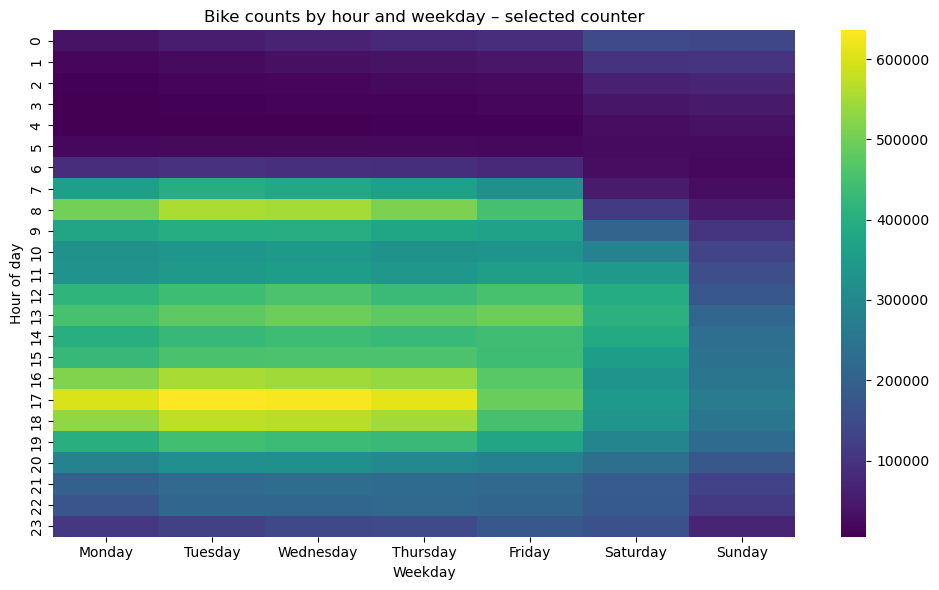

In [46]:
# Heatmap plot with axes time and day of week for selected counter

# Extract hour and weekday
bike_data_selected['hour'] = bike_data_selected['timestamp'].dt.hour
bike_data_selected['weekday'] = bike_data_selected['timestamp'].dt.day_name()

# Aggregate counts
heat_df = bike_data_selected.pivot_table(
    index='hour',
    columns='weekday',
    values='count',
    aggfunc='sum',
    fill_value=0
)

# Order weekdays Monday–Sunday
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heat_df = heat_df.reindex(columns=weekday_order)

plt.figure(figsize=(10, 6))
sns.heatmap(heat_df, cmap='viridis')
plt.title('Bike counts by hour and weekday – selected counter')
plt.xlabel('Weekday')
plt.ylabel('Hour of day')
plt.tight_layout()
plt.show()

C:\Users\kraus\AppData\Local\Temp\ipykernel_2560\336115185.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_data_selected['hour'] = bike_data_selected['timestamp'].dt.hour
C:\Users\kraus\AppData\Local\Temp\ipykernel_2560\336115185.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_data_selected['day_of_year'] = bike_data_selected['timestamp'].dt.dayofyear


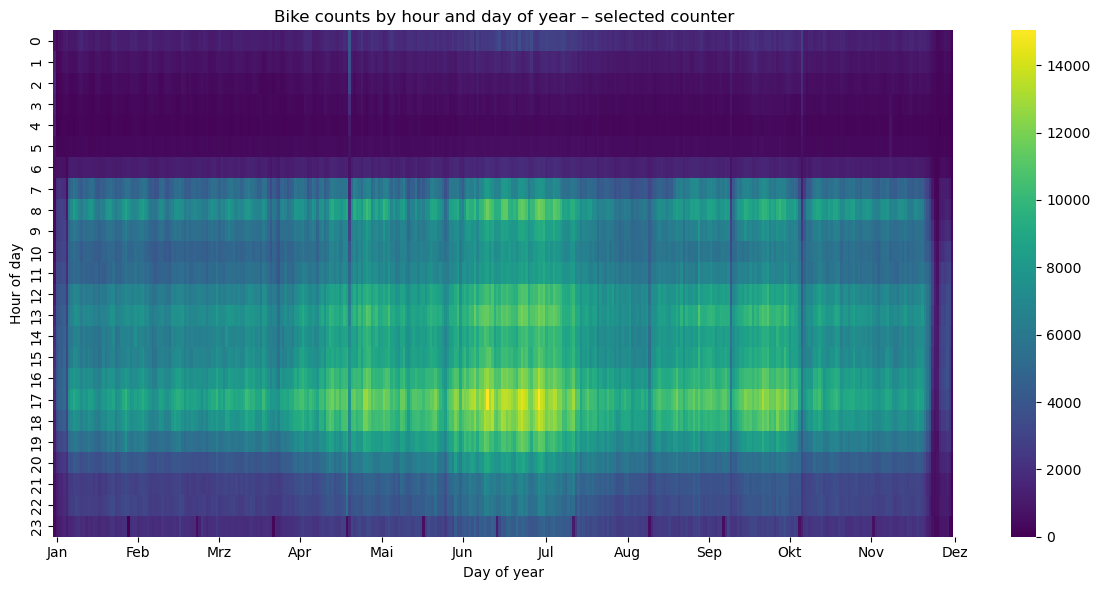

In [47]:
# Heatmap plot with axes time and day of year for selected counter

# Extract hour and day of year
bike_data_selected['hour'] = bike_data_selected['timestamp'].dt.hour
bike_data_selected['day_of_year'] = bike_data_selected['timestamp'].dt.dayofyear

# Aggregate counts
heat_df = bike_data_selected.pivot_table(
    index='hour',
    columns='day_of_year',
    values='count',
    aggfunc='sum',
    fill_value=0
)

# Spalten nach Tag-im-Jahr sortieren (x-Achse)
heat_df = heat_df.reindex(sorted(heat_df.columns), axis=1)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(heat_df, cmap='viridis')
plt.title('Bike counts by hour and day of year – selected counter')
plt.xlabel('Day of year')
plt.ylabel('Hour of day')

# Tick-Positionen und Labels (Monate)
if not heat_df.empty:
    min_day, max_day = heat_df.columns.min(), heat_df.columns.max()
    ticks = np.linspace(min_day, max_day, 12, dtype=int)
    base_year = int(bike_data_selected['timestamp'].dt.year.mode().iloc[0])
    labels = pd.to_datetime(ticks - 1, unit='D', origin=f'{base_year}-01-01').strftime('%b')
    ax.set_xticks(ticks + 0.5)  # center ticks
    ax.set_xticklabels(labels, rotation=0)

plt.tight_layout()
plt.show()